##### Copyright 2019 The TF-Agents Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### CheckpointerとPolicySaver

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/10_checkpointer_policysaver_tutorial.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/agents/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## はじめに

`tf_agents.utils.common.Checkpointer`は、ローカルストレージとの間でトレーニングの状態、ポリシーの状態、およびreplay_bufferの状態を保存/読み込むユーティリティです。

`tf_agents.policies.policy_saver.PolicySaver`は、ポリシーのみを保存/読み込むツールであり、`Checkpointer`よりも軽量です。`PolicySaver`を使用すると、ポリシーを作成したコードに関する知識がなくてもモデルをデプロイできます。

このチュートリアルでは、DQNを使用してモデルをトレーニングし、次に`Checkpointer`と`PolicySaver`を使用して、状態とモデルをインタラクティブな方法で保存および読み込む方法を紹介します。`PolicySaver`では、TF2.0の新しいsaved_modelツールとフォーマットを使用することに注意してください。


## セットアップ

以下の依存関係をインストールしていない場合は、実行します。

In [2]:
#@test {"skip": true}
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q 'pyglet==1.3.2'
!pip install -q 'xvfbwrapper==0.2.9'
!pip install -q tf-agents



ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).


The following packages were automatically installed and are no longer required:
  adwaita-icon-theme ca-certificates-java dconf-gsettings-backend
  dconf-service default-jre default-jre-headless dkms fonts-dejavu-extra
  freeglut3 freeglut3-dev g++-6 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme java-common libaccinj64-9.1
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcairo-gobject2 libcolord2 libcudart9.1 libcufft9.1
  libcufftw9.1 libcups2 libcurand9.1 libcusolver9.1 libcusparse9.1 libdconf1
  libdrm-dev libegl-mesa0 libegl1 libegl1-mesa libepoxy0 libgbm1 libgif7
  libgl1-mesa-dev libgles1 libgles2 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libgtk-3-0 libgtk-3-common libgtk2.0-0
  libgtk2.0-common libice-dev libjansson4 libjson-glib-1.0-

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

try:
  from google.colab import files
except ImportError:
  files = None
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [4]:
#@test {"skip": true}
# Set up a virtual display for rendering OpenAI gym environments.
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

## DQNエージェント

前のColabと同じように、DQNエージェントを設定します。 このColabでは、詳細は主な部分ではないので、デフォルトでは非表示になっていますが、「コードを表示」をクリックすると詳細を表示できます。

### ハイパーパラメーター

In [5]:
env_name = "CartPole-v1"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

### 環境

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### エージェント

In [7]:
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()

### データ収集

In [8]:
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


### エージェントのトレーニング

In [9]:
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  iteration = agent.train_step_counter.numpy()
  print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

### ビデオ生成

In [10]:
#@title
def embed_gif(gif_buffer):
  """Embeds a gif file in the notebook."""
  tag = '<img src="data:image/gif;base64,{0}"/>'.format(base64.b64encode(gif_buffer).decode())
  return IPython.display.HTML(tag)

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
  num_episodes = 3
  frames = []
  for _ in range(num_episodes):
    time_step = eval_tf_env.reset()
    frames.append(eval_py_env.render())
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = eval_tf_env.step(action_step.action)
      frames.append(eval_py_env.render())
  gif_file = io.BytesIO()
  imageio.mimsave(gif_file, frames, format='gif', fps=60)
  IPython.display.display(embed_gif(gif_file.getvalue()))

### ビデオ生成

ビデオを生成して、ポリシーのパフォーマンスを確認します。

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>



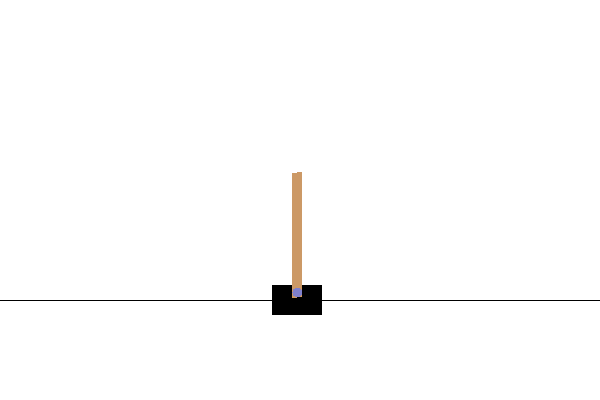

In [11]:
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

## チェックポインタとPolicySaverのセットアップ

CheckpointerとPolicySaverを使用する準備ができました。

### Checkpointer


In [12]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

### Policy Saver

In [13]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

### 1回のイテレーションのトレーニング

In [14]:
#@test {"skip": true}
print('Training one iteration....')
train_one_iteration()

Training one iteration....


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


iteration: 1 loss: 1.025463342666626


### チェックポイントに保存

In [15]:
train_checkpointer.save(global_step)

### チェックポイントに復元

チェックポイントに復元するためには、チェックポイントが作成されたときと同じ方法でオブジェクト全体を再作成する必要があります。

In [16]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

また、ポリシーを保存して指定する場所にエクスポートします。

In [17]:
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


ポリシーの作成に使用されたエージェントまたはネットワークについての知識がなくても、ポリシーを読み込めるので、ポリシーのデプロイが非常に簡単になります。

保存されたポリシーを読み込み、それがどのように機能するかを確認します。


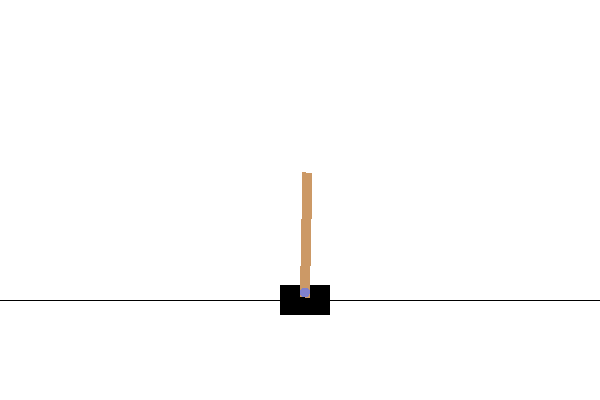

In [18]:
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

## エクスポートとインポート

以下は、Checkpointerとポリシーディレクトリのエクスポート/インポートに役立ち、後でトレーニングを継続して、再度トレーニングすることなくモデルをデプロイできます。

「1回のイテレーションのトレーニング」に戻り、後で違いを理解できるように、さらに数回トレーニングします。 結果が少し改善し始めたら、以下に進みます。

In [19]:
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

チェックポイントディレクトリからzipファイルを作成します。

In [20]:
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

zipファイルをダウンロードします。

In [21]:
#@test {"skip": true}
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

10〜15回ほどトレーニングした後、チェックポイントのzipファイルをダウンロードし、[ランタイム]> [再起動してすべて実行]に移動してトレーニングをリセットし、このセルに戻ります。ダウンロードしたzipファイルをアップロードして、トレーニングを続けます。

In [22]:
#@test {"skip": true}
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

チェックポイントディレクトリをアップロードしたら、「1回のイテレーションのトレーニング」に戻ってトレーニングを続けるか、「ビデオ生成」に戻って読み込まれたポリシーのパフォーマンスを確認します。

または、ポリシー（モデル）を保存して復元することもできます。Checkpointerとは異なり、トレーニングを続けることはできませんが、モデルをデプロイすることはできます。ダウンロードしたファイルはCheckpointerのファイルよりも大幅に小さいことに注意してください。

In [23]:
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


In [24]:
#@test {"skip": true}
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

ダウンロードしたポリシーディレクトリ（exported_policy.zip）をアップロードし、保存したポリシーの動作を確認します。


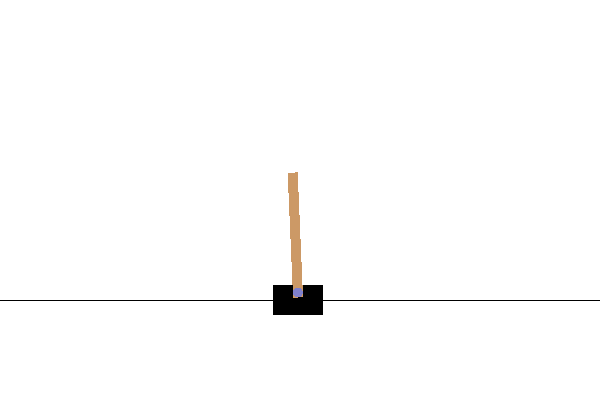

In [25]:
#@test {"skip": true}
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)


## SavedModelPyTFEagerPolicy

TFポリシーを使用しない場合は、`py_tf_eager_policy.SavedModelPyTFEagerPolicy`を使用して、Python envでsaved_modelを直接使用することもできます。

これは、eagerモードが有効になっている場合にのみ機能することに注意してください。


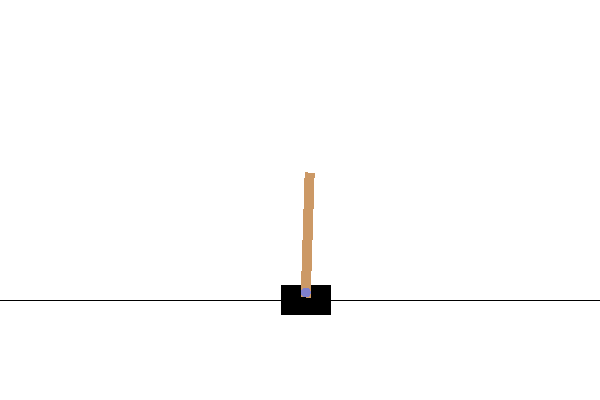

In [26]:
eager_py_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    policy_dir, eval_py_env.time_step_spec(), eval_py_env.action_spec())

# Note that we're passing eval_py_env not eval_env.
run_episodes_and_create_video(eager_py_policy, eval_py_env, eval_py_env)